In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Load the data
df = pd.read_csv(
    '../data/processed/num_tourists_total.csv',
    sep=';',
    parse_dates=['Period'],
    index_col='Period'
 )

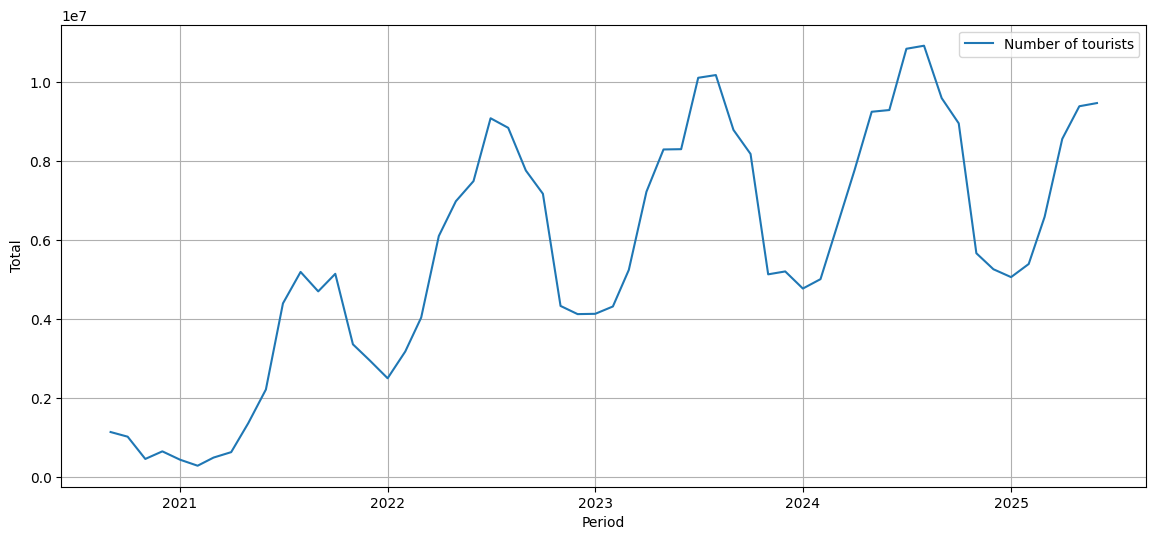

In [3]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, y="Total", x="Period", label="Number of tourists")
plt.grid()

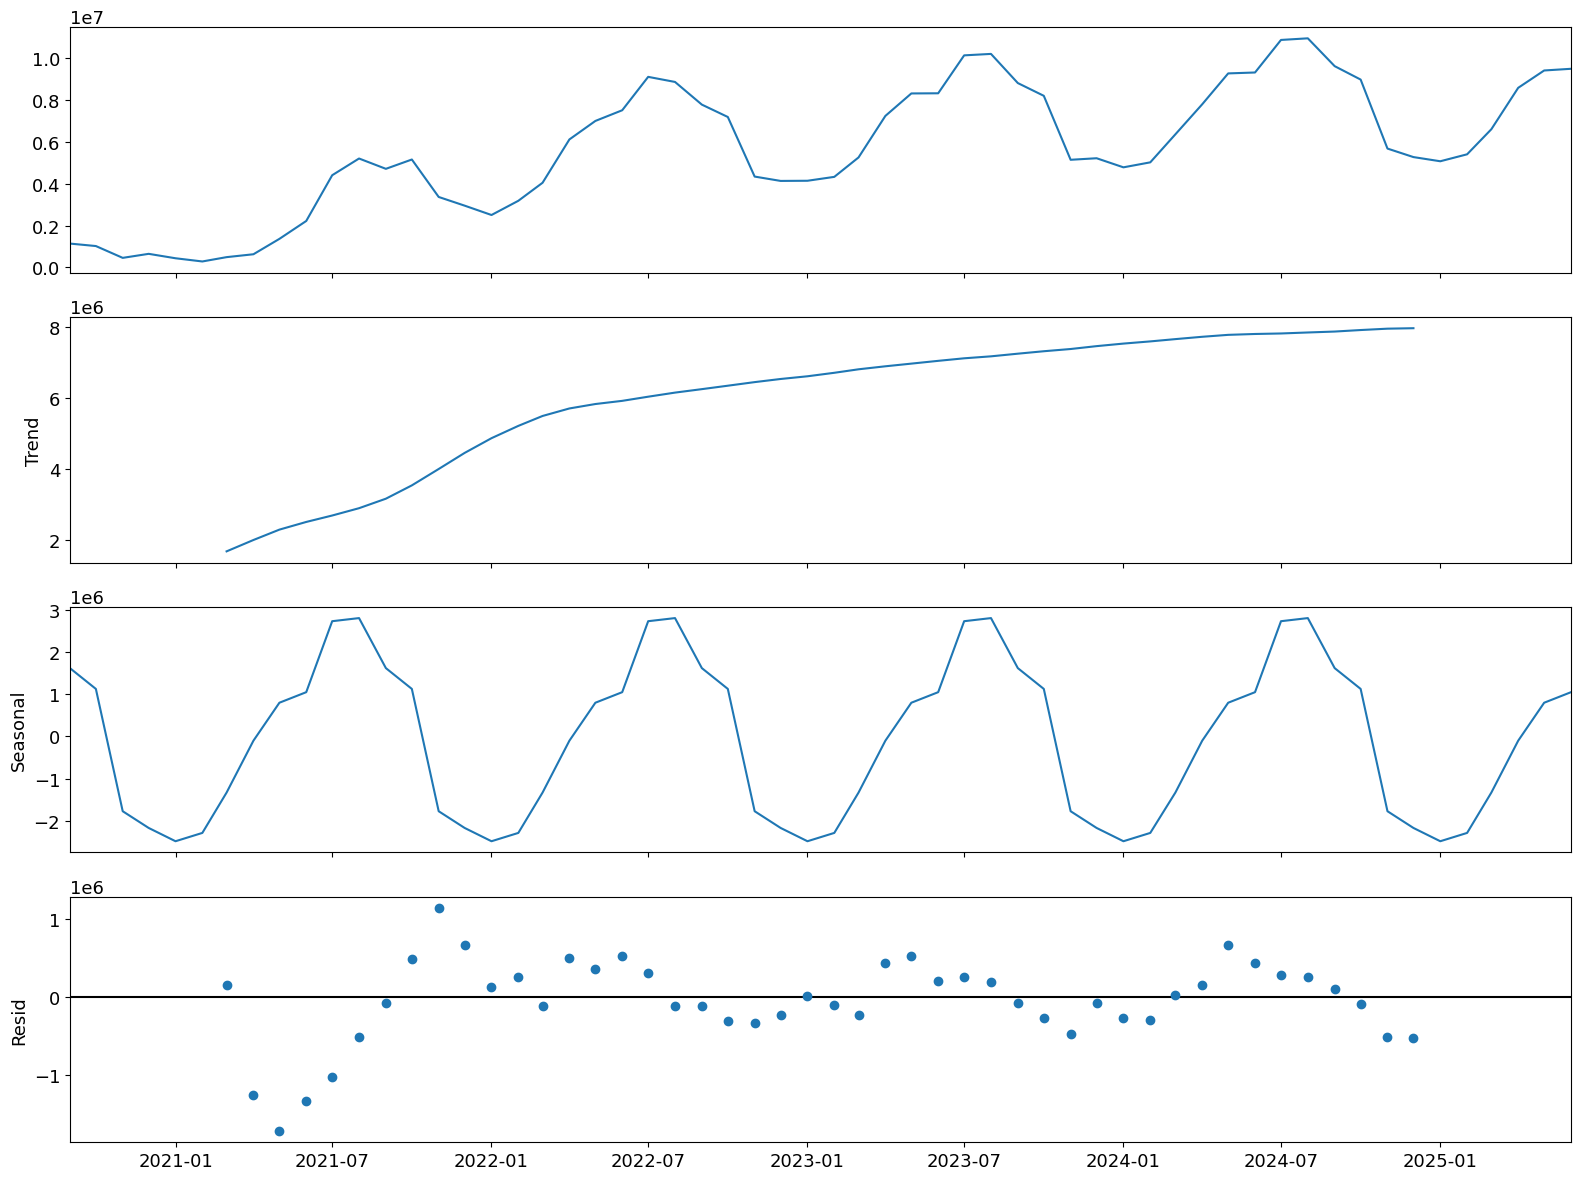

In [8]:
# Additive decomposition
Additive_decomposition = seasonal_decompose(df, model="additive", period=12)

# Plot the components
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
fig = Additive_decomposition.plot()
plt.show()

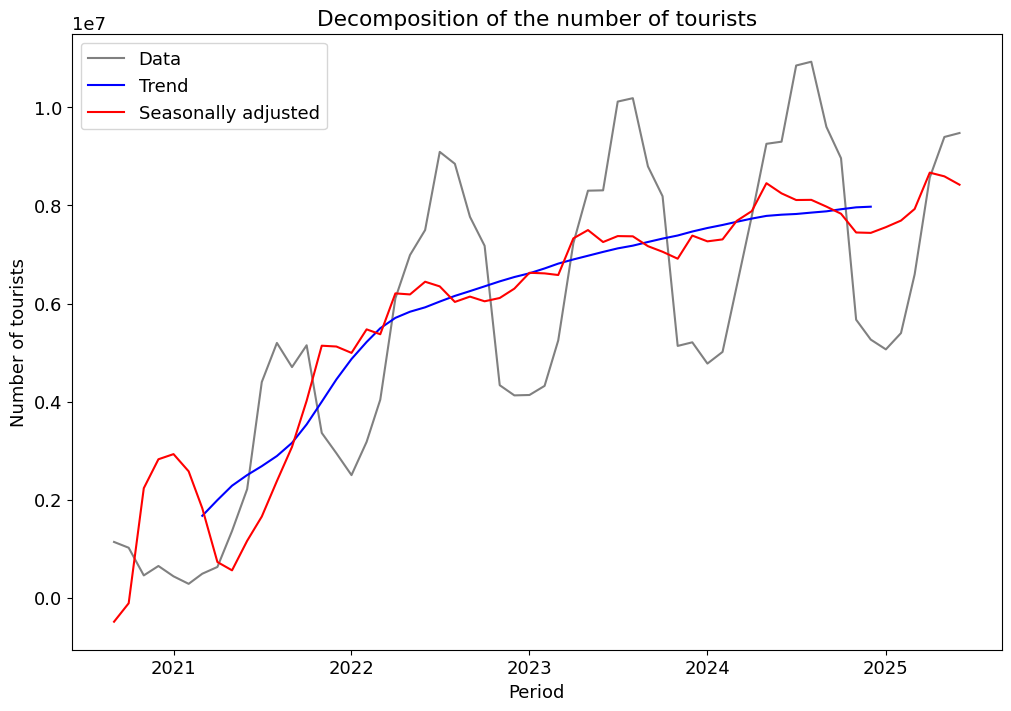

In [9]:
# Seasonally adjusted series
valid_idx = Additive_decomposition.seasonal.notna()
Seasonally_Adjusted = df['Total'][valid_idx] - Additive_decomposition.seasonal[valid_idx]

# Plot the original series, trend, and seasonally adjusted series
plt.figure(figsize=(12, 8))
plt.plot(df, label="Data", color="gray")
plt.plot(Additive_decomposition.trend, label="Trend", color="blue")
plt.plot(Seasonally_Adjusted, label="Seasonally adjusted", color="red")
plt.xlabel("Period")
plt.ylabel("Number of tourists")
plt.title("Decomposition of the number of tourists")
plt.legend()
plt.show()

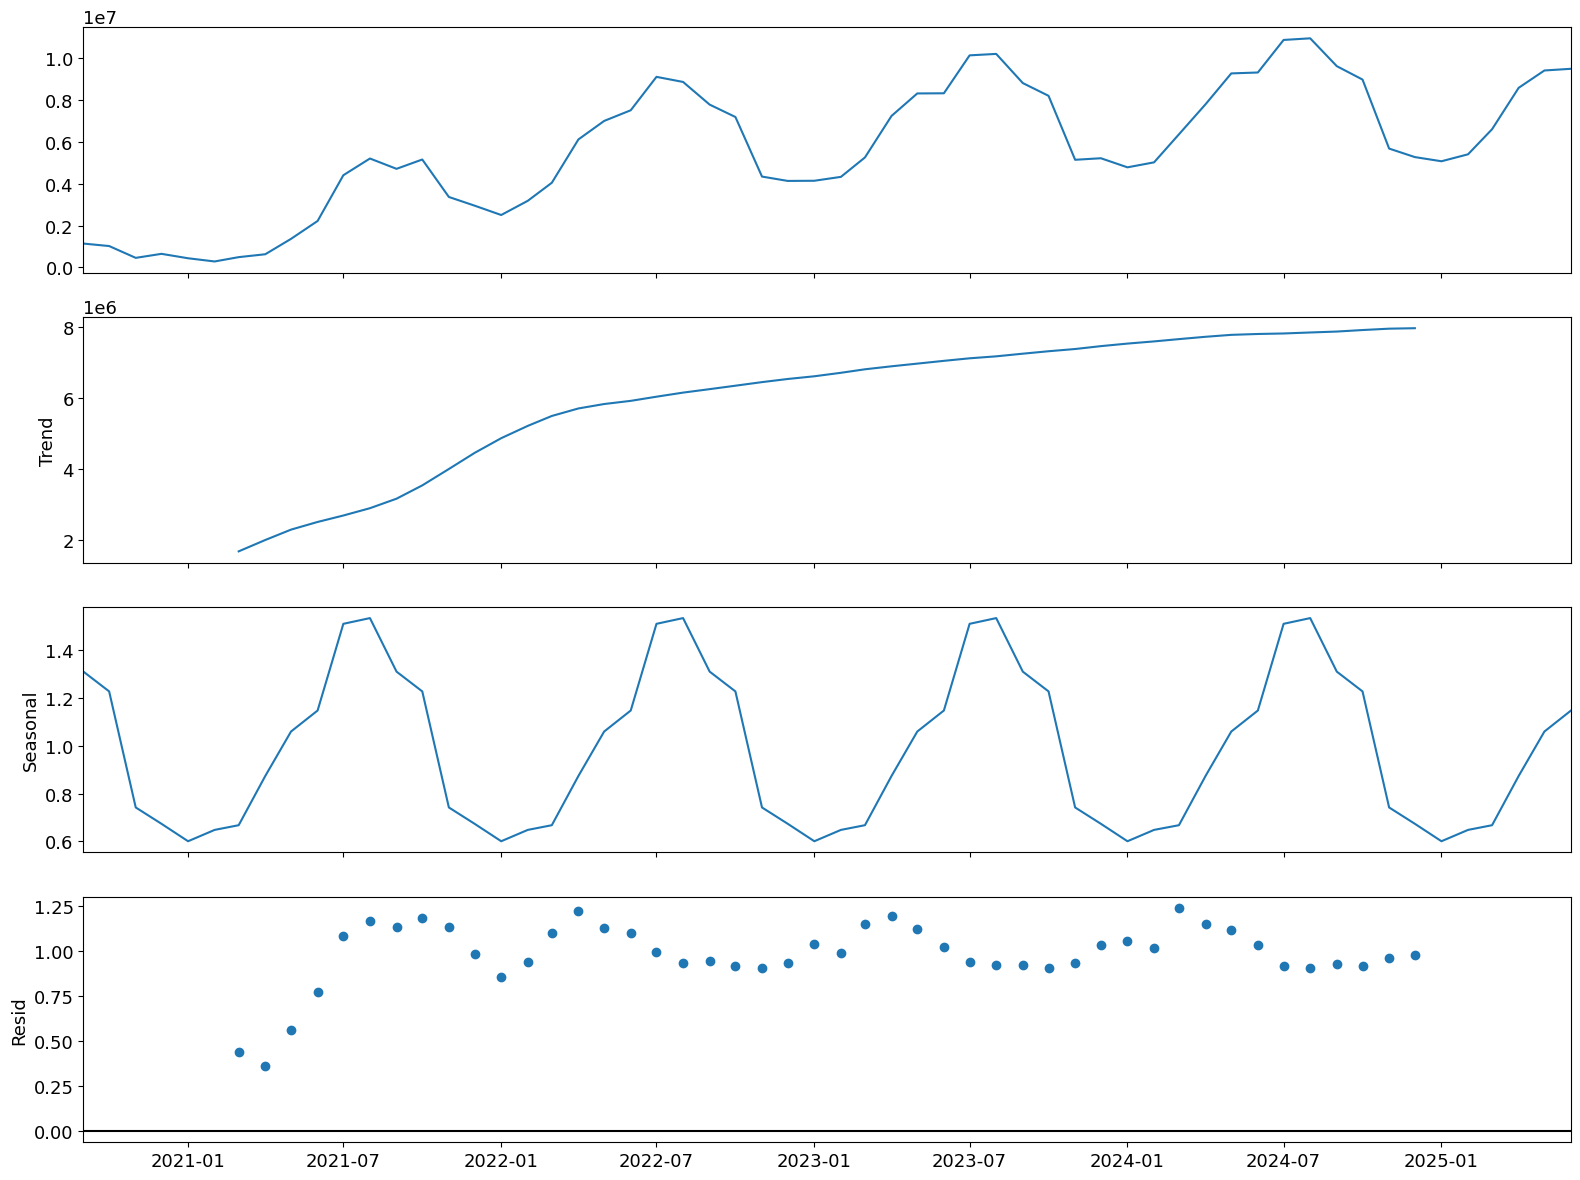

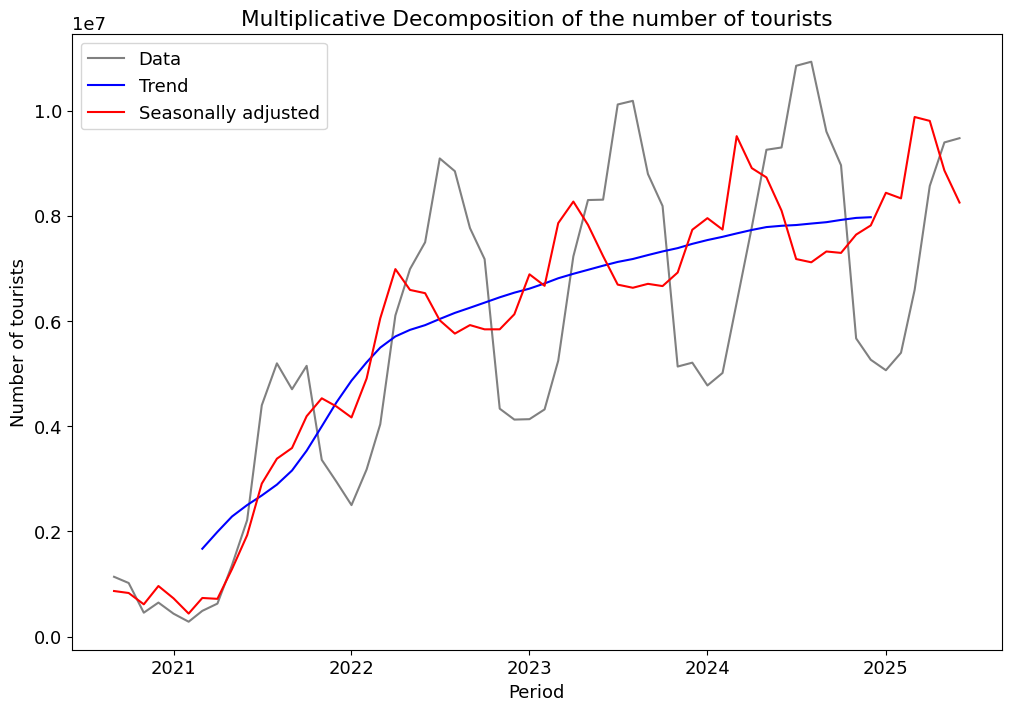

In [10]:
# Multiplicative decomposition
Mult_decomposition = seasonal_decompose(df, model="multiplicative", period=12)

# Plot the components
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
fig = Mult_decomposition.plot()
plt.show()

# Seasonally adjusted series
Seasonally_Adjusted = df['Total'] / Mult_decomposition.seasonal

# Plot the original series, trend, and seasonally adjusted series
plt.figure(figsize=(12, 8))
plt.plot(df, label="Data", color="gray")
plt.plot(Mult_decomposition.trend, label="Trend", color="blue")
plt.plot(Seasonally_Adjusted, label="Seasonally adjusted", color="red")
plt.xlabel("Period")
plt.ylabel("Number of tourists")
plt.title("Multiplicative Decomposition of the number of tourists")
plt.legend()
plt.show()

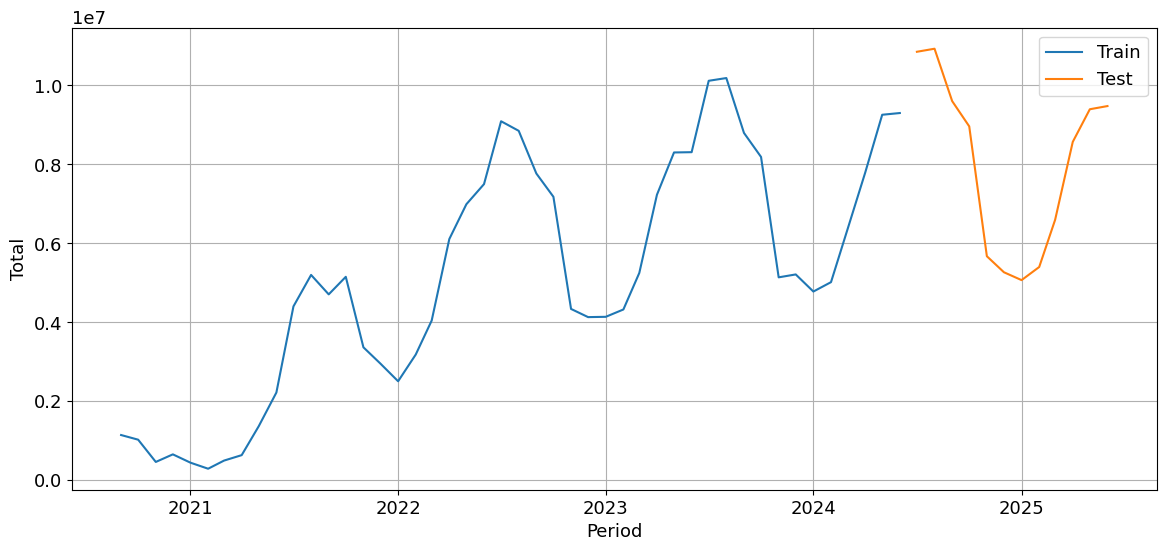

In [11]:
test_size = 12

df_complete = df
train_size = df_complete.shape[0] - test_size

df_train = df_complete.iloc[:train_size]
df_test = df_complete.iloc[train_size:]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="Total", x="Period", label="Train")
sns.lineplot(data=df_test, y="Total", x="Period", label="Test")
plt.grid()

/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Errors (MAE): {'Simple Exponential Smoothing': 1944525.7498917456, 'Holt': 3031094.107377125, 'Holt-Winters': 1814555.5228571903}


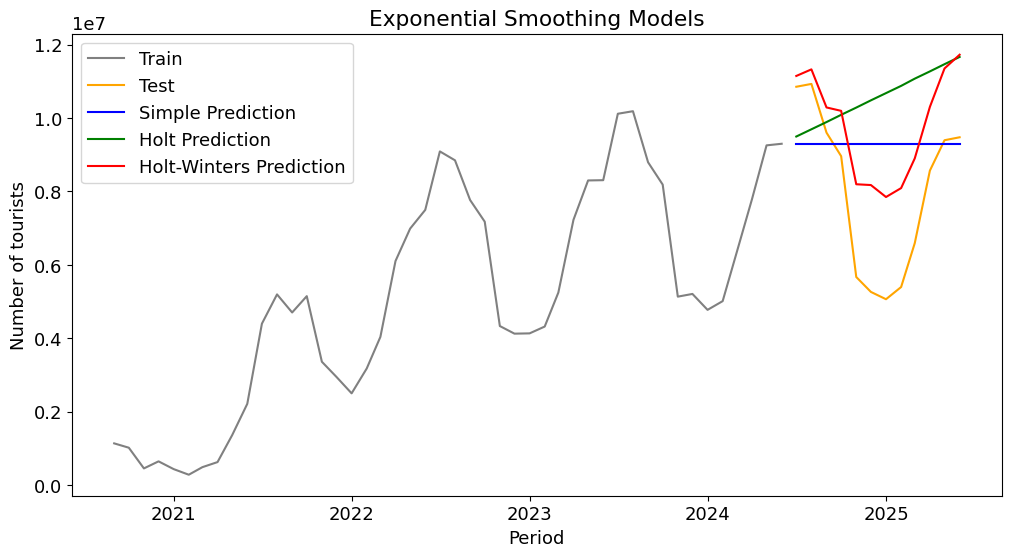

In [12]:
from statsmodels.tsa.api import ExponentialSmoothing

# Split data into TRAIN and TEST
train = df_train["Total"]
test = df_test["Total"]

# Simple Exponential Smoothing
model_simple = ExponentialSmoothing(train, initialization_method="estimated").fit()
fcast_simple = model_simple.forecast(len(test))

# Holt's Method
model_holt = ExponentialSmoothing(train, trend="add", initialization_method="estimated").fit()
fcast_holt = model_holt.forecast(len(test))

# Holt-Winters Method (if seasonality exists)
model_hw = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated").fit()
fcast_hw = model_hw.forecast(len(test))

# Compare errors
from sklearn.metrics import mean_absolute_error
errors = {
    "Simple Exponential Smoothing": mean_absolute_error(test, fcast_simple),
    "Holt": mean_absolute_error(test, fcast_holt),
    "Holt-Winters": mean_absolute_error(test, fcast_hw),
}

print("Errors (MAE):", errors)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train", color="gray")
plt.plot(test, label="Test", color="orange")
plt.plot(fcast_simple, label="Simple Prediction", color="blue")
plt.plot(fcast_holt, label="Holt Prediction", color="green")
plt.plot(fcast_hw, label="Holt-Winters Prediction", color="red")
plt.legend()
plt.xlabel("Period")
plt.ylabel("Number of tourists")
plt.title("Exponential Smoothing Models")
plt.show()
# ARIMA fitting

In [13]:
# Training with auto_arima
model = auto_arima(df['Total'],
                    seasonal=True,
                    m=12,  # annual seasonality
                    stepwise=True,
                    suppress_warnings=True,
                    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=5.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1323.122, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1323.736, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1324.601, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1336.680, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1357.584, Time=0.27 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1471.675, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1322.330, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1323.772, Time=0.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1325.719, Time=1.46 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1321.331, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1322.331, Time=0.43 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1322.401, Time=0.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1324.293, Time=0.60 sec
 ARIMA(3,1,0)(0,1,0)[12]

/tmp/ipykernel_33538/3905666367.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=n_periods + 1, freq='M')[1:], forecast, label='Forecast', color='orange')
/tmp/ipykernel_33538/3905666367.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.fill_between(pd.date_range(start=df.index[-1], periods=n_periods + 1, freq='M')[1:],


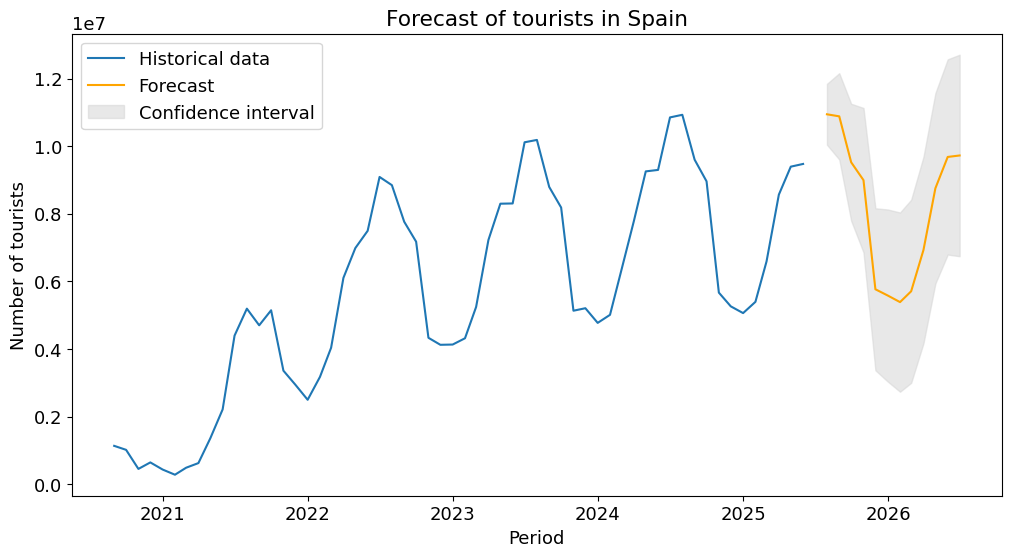

In [14]:
# Predict the next 12 months
n_periods = 12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df, label='Historical data')
plt.plot(pd.date_range(start=df.index[-1], periods=n_periods + 1, freq='M')[1:], forecast, label='Forecast', color='orange')
plt.fill_between(pd.date_range(start=df.index[-1], periods=n_periods + 1, freq='M')[1:],
                 conf_int[:, 0], conf_int[:, 1], color='lightgray', alpha=0.5, label='Confidence interval')
plt.title('Forecast of tourists in Spain')
plt.xlabel('Period')
plt.ylabel('Number of tourists')
plt.legend()
plt.show()

In [15]:
import joblib

# Save model
joblib.dump(model, '../models/arima_model_total.pkl')


['../models/arima_model_total.pkl']